/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 1.00
Testing Accuracy: 0.93
Real Testing Accuracy: 0.42


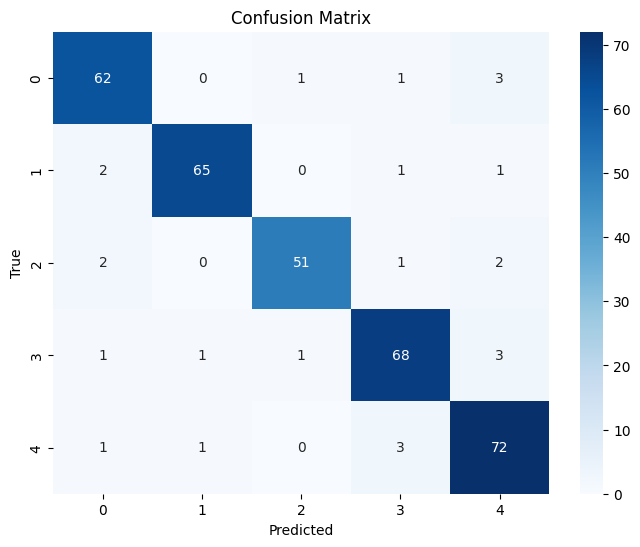

False Negative Rate (FNR) for each class:
Class 0: FNR = 0.07
Class 1: FNR = 0.06
Class 2: FNR = 0.09
Class 3: FNR = 0.08
Class 4: FNR = 0.06
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        67
           1       0.97      0.94      0.96        69
           2       0.96      0.91      0.94        56
           3       0.92      0.92      0.92        74
           4       0.89      0.94      0.91        77

    accuracy                           0.93       343
   macro avg       0.93      0.93      0.93       343
weighted avg       0.93      0.93      0.93       343



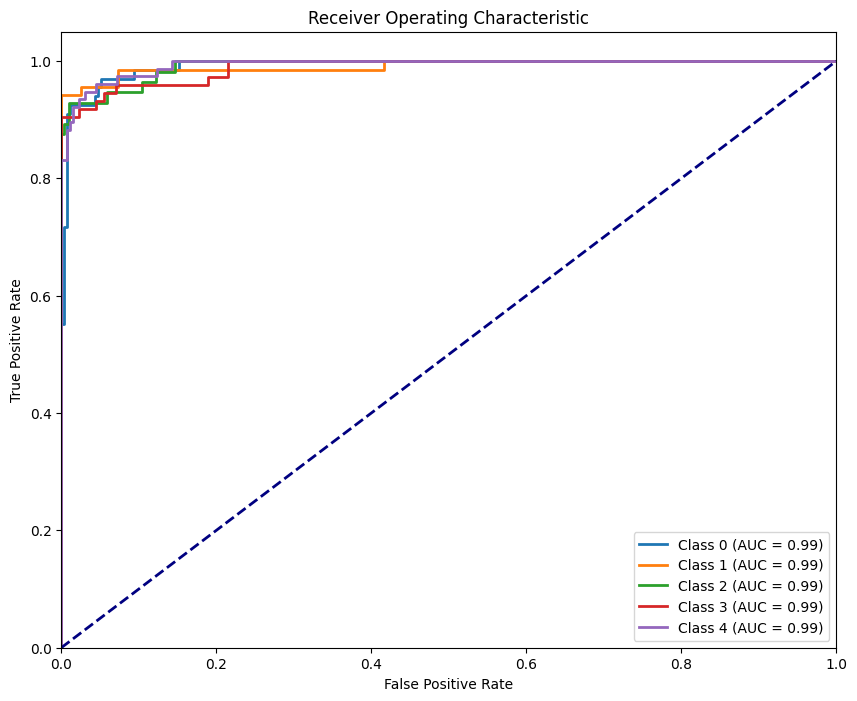

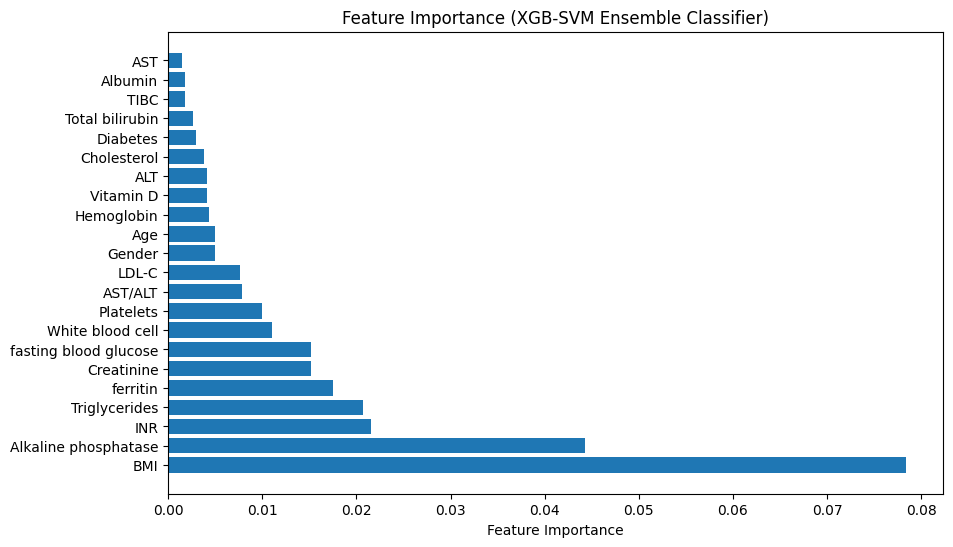

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load and preprocess training data
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load and preprocess external test data
test_data = pd.read_excel('/content/test_data_1.xlsx')
test_data.fillna(test_data.mean(numeric_only=True), inplace=True)


# Split features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the internal data into training and 20% test split
X_train, X_internal_test, y_train, y_internal_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_internal_test, test_data.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_internal_test, test_data['steato score']], axis=0)


# Define base models
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    learning_rate=0.1,
    max_depth=6,
    n_estimators=250,
    scale_pos_weight=1,
    eval_metric='mlogloss'
)
svm_model = SVC(probability=True, class_weight='balanced', C=1, gamma=0.1, kernel='rbf')

# Define and train Voting Classifier
voting_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('svm', svm_model)],
    voting='soft'
)
voting_model.fit(X_train, y_train)

# Check accuracy on test set
train_acc = voting_model.score(X_train, y_train)
test_acc = voting_model.score(X_test_combined, y_test_combined)
real_test_acc = voting_model.score(test_data.drop('steato score', axis=1), test_data['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"Real Testing Accuracy: {real_test_acc:.2f}")

# Predict on combined test set
y_pred = voting_model.predict(X_test_combined)

# Compute confusion matrix
cm = confusion_matrix(y_test_combined, y_pred)
classes = np.unique(y_test_combined)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute and display FNR for each class
fnr = {}
for i, cls in enumerate(classes):
    FN = cm[i, :].sum() - cm[i, i]  # False negatives for class i
    TP = cm[i, i]  # True positives for class i
    fnr[cls] = FN / (FN + TP) if (FN + TP) != 0 else 0

print("False Negative Rate (FNR) for each class:")
for cls, rate in fnr.items():
    print(f"Class {cls}: FNR = {rate:.2f}")

# Display classification report
print("Classification Report:")
target_names = [str(cls) for cls in classes]
print(classification_report(y_test_combined, y_pred, target_names=target_names))


# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), voting_model.predict_proba(X_test_combined)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Feature Importance
results = permutation_importance(voting_model, X_test_combined, y_test_combined, scoring='accuracy', n_repeats=10, random_state=42)
importance_scores = results.importances_mean
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importance_scores[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (XGB-SVM Ensemble Classifier)')
plt.show()


Top Features for Class 0 based on predict_proba:
Creatinine: 0.0020
Hemoglobin: 0.0015
ALT: 0.0009
Total bilirubin: 0.0006
ferritin: 0.0006
fasting blood glucose: 0.0003
AST: 0.0000
White blood cell: -0.0003
INR: -0.0012
TIBC: -0.0017
Albumin: -0.0020
Cholesterol: -0.0026
Vitamin D: -0.0026
Diabetes: -0.0029
Triglycerides: -0.0032
Gender: -0.0035
Age: -0.0050
AST/ALT: -0.0067
LDL-C: -0.0093
Platelets: -0.0099
BMI: -0.0259
Alkaline phosphatase: -0.0259


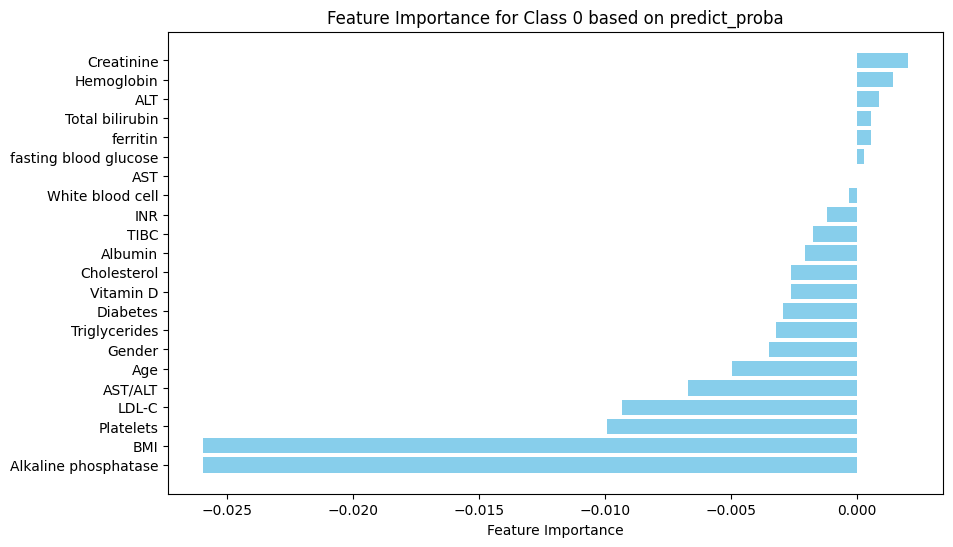


Top Features for Class 1 based on predict_proba:
Alkaline phosphatase: 0.0155
INR: 0.0131
fasting blood glucose: 0.0073
Triglycerides: 0.0047
Creatinine: 0.0029
Hemoglobin: 0.0017
ferritin: 0.0015
ALT: 0.0012
AST: 0.0006
White blood cell: -0.0006
Cholesterol: -0.0012
Diabetes: -0.0012
Vitamin D: -0.0017
Total bilirubin: -0.0017
TIBC: -0.0017
Gender: -0.0020
Albumin: -0.0023
Age: -0.0029
Platelets: -0.0058
AST/ALT: -0.0061
LDL-C: -0.0070
BMI: -0.0120


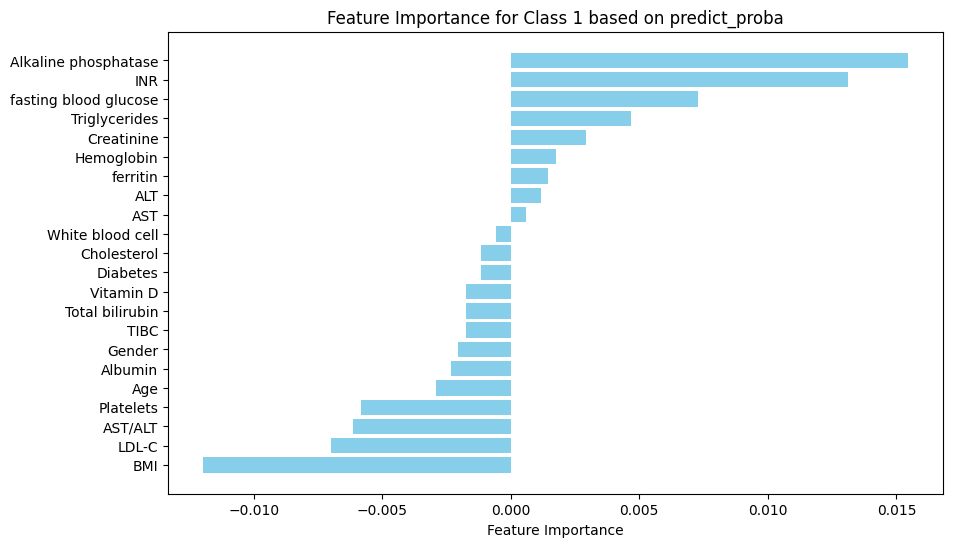


Top Features for Class 2 based on predict_proba:
Creatinine: 0.0058
Triglycerides: 0.0052
ALT: 0.0041
Hemoglobin: 0.0038
fasting blood glucose: 0.0029
ferritin: 0.0020
Total bilirubin: 0.0017
White blood cell: 0.0009
Vitamin D: 0.0006
Diabetes: -0.0009
Albumin: -0.0012
INR: -0.0015
Platelets: -0.0015
TIBC: -0.0017
AST: -0.0020
Cholesterol: -0.0023
Age: -0.0023
Gender: -0.0023
LDL-C: -0.0052
AST/ALT: -0.0058
BMI: -0.0114
Alkaline phosphatase: -0.0268


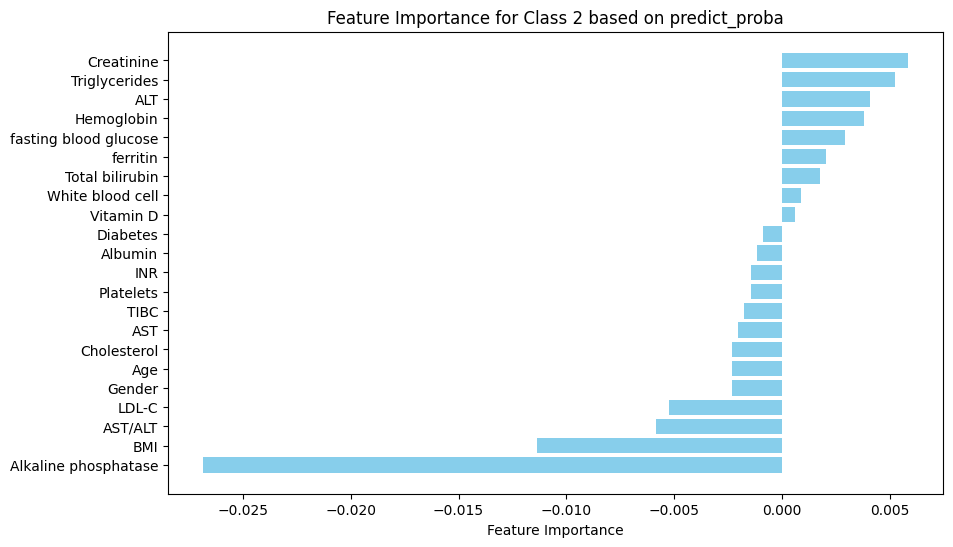


Top Features for Class 3 based on predict_proba:
Triglycerides: 0.0131
fasting blood glucose: 0.0082
Creatinine: 0.0082
ferritin: 0.0052
ALT: 0.0050
Hemoglobin: 0.0044
White blood cell: 0.0041
Total bilirubin: 0.0015
AST: 0.0009
INR: 0.0006
Gender: 0.0003
Diabetes: 0.0003
TIBC: 0.0000
Age: -0.0006
Vitamin D: -0.0012
Albumin: -0.0015
Cholesterol: -0.0023
Platelets: -0.0038
BMI: -0.0041
AST/ALT: -0.0047
LDL-C: -0.0085
Alkaline phosphatase: -0.0254


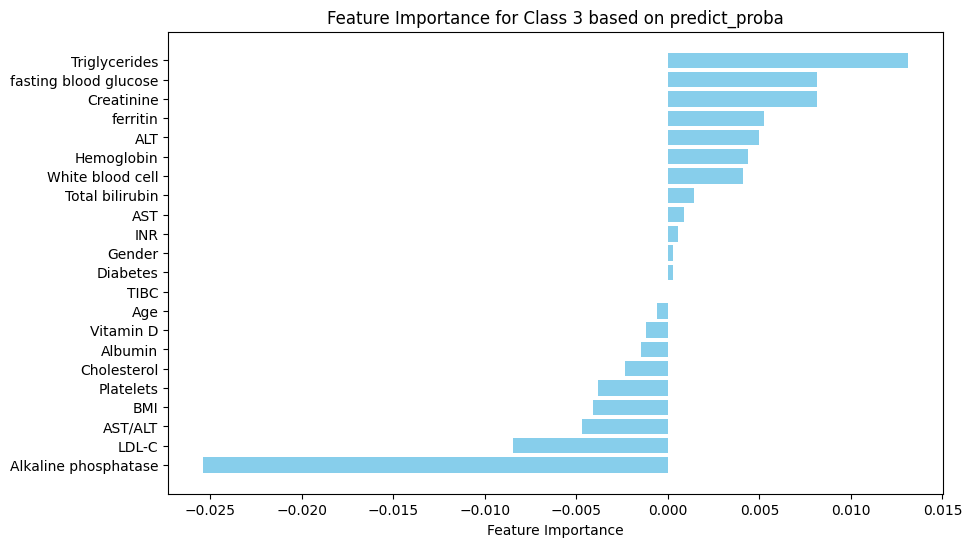


Top Features for Class 4 based on predict_proba:
BMI: 0.0105
ferritin: 0.0047
Triglycerides: 0.0047
ALT: 0.0041
Creatinine: 0.0038
fasting blood glucose: 0.0026
Hemoglobin: 0.0023
White blood cell: 0.0023
AST: 0.0006
Total bilirubin: 0.0003
Cholesterol: -0.0006
INR: -0.0006
Gender: -0.0006
Age: -0.0009
Diabetes: -0.0009
TIBC: -0.0017
Albumin: -0.0023
Vitamin D: -0.0032
AST/ALT: -0.0035
Platelets: -0.0070
LDL-C: -0.0076
Alkaline phosphatase: -0.0254


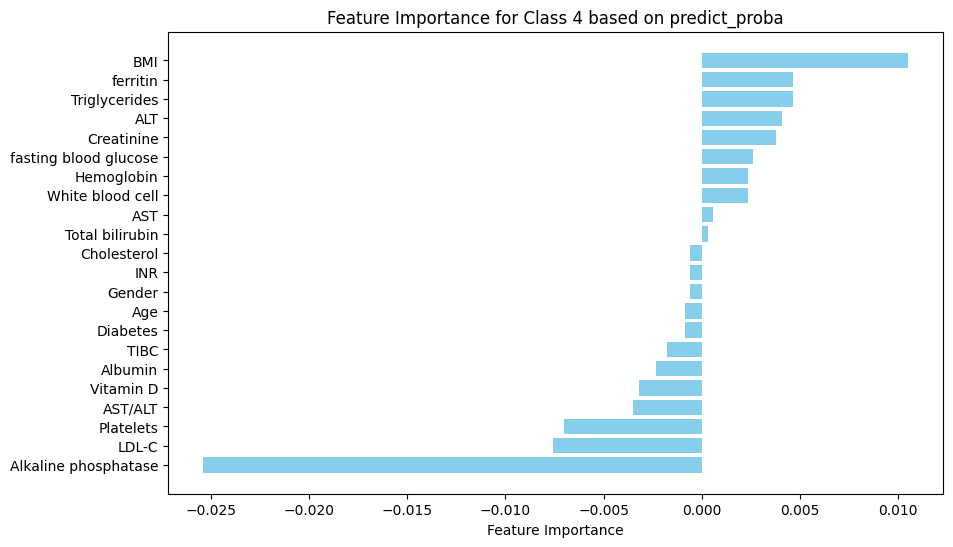

In [6]:
from sklearn.inspection import permutation_importance

# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba = {}

# Loop over each class in the model
for class_index, cls in enumerate(voting_model.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = voting_model.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    importance_scores = permutation_importance(
        voting_model, X_test_combined, y_binary,
        scoring='accuracy', n_repeats=10, random_state=42
    ).importances_mean

    # Sort by importance (descending)
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Save results for later use (optional)
    feature_importances_per_class_proba[cls] = {
        "features": sorted_features,
        "scores": sorted_scores
    }

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
